# Experiment 2 - Classification of Malignancy using images only
This notebook contains the code to classify the nodules as malignant / benign using the 3D image bounding boxes only. The data would consist of the 3D Volume and malignancy pairs. 
We perform classification for 2 distributions of the dataset.
1. R12 vs R45
2. R123 vs R345

Set R3 contains nodules with malignancy 3. They are classified into the malignant and benign class in the pre triaining phase by using a KNN with K = 21. This is the semi supervised step.

We plot a ROC curve at the end of training on each of the distributions and compare the results.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
from collections import Counter, defaultdict
from keras import optimizers
from keras.layers import Conv3D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras import regularizers

Using TensorFlow backend.


In [ ]:
data = np.load('gdrive/My Drive/Thesis/Dataset/LIDC_Latest.npy', allow_pickle = True)

In [ ]:
df = pd.DataFrame({'subtlety':data[:,0],
                           'internalStructure':data[:,1],
                           'calcification':data[:,2],
                           'sphericity':data[:,3],
                           'margin':data[:,4],
                           'lobulation':data[:,5],
                           'spiculation':data[:,6],
                           'texture':data[:,7],
                           'Malignancy':data[:,8],
                           'Patient_id':data[:,9],
                           '3D Volume':data[:,10],
                           '3D Mask':data[:,11]})

## For a subset of approximately 100 cases from among the initial 399 cases released, inconsistent rating systems were used among the 5 sites with regard to the spiculation and lobulation characteristics of lesions identified as nodules > 3 mm. The XML nodule characteristics data as it exists for some cases will be impacted by this error. 

We do not know which 100 are inconsistent but we know which LIDC scans were the in the initial release. So let's exlude this.

The list of patient ID's that have inconsistent ratings can be found on the LIDC Website  -> https://wiki.cancerimagingarchive.net/download/attachments/1966254/NBIAtoTCIA-patientIDs-official.xls?version=1&modificationDate=1334864796218&api=v2

In [ ]:
exclude_list = ['LIDC-IDRI-0098', 'LIDC-IDRI-0292', 'LIDC-IDRI-0294', 'LIDC-IDRI-0296', 'LIDC-IDRI-0297', 'LIDC-IDRI-0301', 'LIDC-IDRI-0302', 'LIDC-IDRI-0303', 'LIDC-IDRI-0304', 'LIDC-IDRI-0306', 'LIDC-IDRI-0309', 'LIDC-IDRI-0310', 'LIDC-IDRI-0314', 'LIDC-IDRI-0316', 'LIDC-IDRI-0317', 'LIDC-IDRI-0318', 'LIDC-IDRI-0319', 'LIDC-IDRI-0320', 'LIDC-IDRI-0322', 'LIDC-IDRI-0323', 'LIDC-IDRI-0324', 'LIDC-IDRI-0325', 'LIDC-IDRI-0329', 'LIDC-IDRI-0330', 'LIDC-IDRI-0332', 'LIDC-IDRI-0334', 'LIDC-IDRI-0335', 'LIDC-IDRI-0336', 'LIDC-IDRI-0337', 'LIDC-IDRI-0338', 'LIDC-IDRI-0342', 'LIDC-IDRI-0343', 'LIDC-IDRI-0344', 'LIDC-IDRI-0348', 'LIDC-IDRI-0349', 'LIDC-IDRI-0351', 'LIDC-IDRI-0352', 'LIDC-IDRI-0354', 'LIDC-IDRI-0355', 'LIDC-IDRI-0356', 'LIDC-IDRI-0357', 'LIDC-IDRI-0359', 'LIDC-IDRI-0361', 'LIDC-IDRI-0362', 'LIDC-IDRI-0364', 'LIDC-IDRI-0365', 'LIDC-IDRI-0369', 'LIDC-IDRI-0371', 'LIDC-IDRI-0373', 'LIDC-IDRI-0375', 'LIDC-IDRI-0376', 'LIDC-IDRI-0377', 'LIDC-IDRI-0379', 'LIDC-IDRI-0380', 'LIDC-IDRI-0381', 'LIDC-IDRI-0384', 'LIDC-IDRI-0385', 'LIDC-IDRI-0386', 'LIDC-IDRI-0387', 'LIDC-IDRI-0390', 'LIDC-IDRI-0391', 'LIDC-IDRI-0396', 'LIDC-IDRI-0398', 'LIDC-IDRI-0400', 'LIDC-IDRI-0401', 'LIDC-IDRI-0404', 'LIDC-IDRI-0405', 'LIDC-IDRI-0407', 'LIDC-IDRI-0409', 'LIDC-IDRI-0410', 'LIDC-IDRI-0411', 'LIDC-IDRI-0412', 'LIDC-IDRI-0413', 'LIDC-IDRI-0414', 'LIDC-IDRI-0416', 'LIDC-IDRI-0417', 'LIDC-IDRI-0419', 'LIDC-IDRI-0420', 'LIDC-IDRI-0425', 'LIDC-IDRI-0431', 'LIDC-IDRI-0433', 'LIDC-IDRI-0435', 'LIDC-IDRI-0436', 'LIDC-IDRI-0437', 'LIDC-IDRI-0438', 'LIDC-IDRI-0439', 'LIDC-IDRI-0441', 'LIDC-IDRI-0446', 'LIDC-IDRI-0448', 'LIDC-IDRI-0449', 'LIDC-IDRI-0451', 'LIDC-IDRI-0453', 'LIDC-IDRI-0454', 'LIDC-IDRI-0456', 'LIDC-IDRI-0457', 'LIDC-IDRI-0462', 'LIDC-IDRI-0463', 'LIDC-IDRI-0465', 'LIDC-IDRI-0467', 'LIDC-IDRI-0469', 'LIDC-IDRI-0471', 'LIDC-IDRI-0472', 'LIDC-IDRI-0474', 'LIDC-IDRI-0478', 'LIDC-IDRI-0479', 'LIDC-IDRI-0480', 'LIDC-IDRI-0482', 'LIDC-IDRI-0484', 'LIDC-IDRI-0486', 'LIDC-IDRI-0487', 'LIDC-IDRI-0488', 'LIDC-IDRI-0490', 'LIDC-IDRI-0492', 'LIDC-IDRI-0493', 'LIDC-IDRI-0494', 'LIDC-IDRI-0498', 'LIDC-IDRI-0499', 'LIDC-IDRI-0500', 'LIDC-IDRI-0502', 'LIDC-IDRI-0503', 'LIDC-IDRI-0505', 'LIDC-IDRI-0508', 'LIDC-IDRI-0511', 'LIDC-IDRI-0512', 'LIDC-IDRI-0513', 'LIDC-IDRI-0514', 'LIDC-IDRI-0516', 'LIDC-IDRI-0517', 'LIDC-IDRI-0519', 'LIDC-IDRI-0520', 'LIDC-IDRI-0525', 'LIDC-IDRI-0526', 'LIDC-IDRI-0527', 'LIDC-IDRI-0528', 'LIDC-IDRI-0530', 'LIDC-IDRI-0531', 'LIDC-IDRI-0536', 'LIDC-IDRI-0537', 'LIDC-IDRI-0538', 'LIDC-IDRI-0543', 'LIDC-IDRI-0544', 'LIDC-IDRI-0547', 'LIDC-IDRI-0548', 'LIDC-IDRI-0550', 'LIDC-IDRI-0551', 'LIDC-IDRI-0552', 'LIDC-IDRI-0556', 'LIDC-IDRI-0557', 'LIDC-IDRI-0558', 'LIDC-IDRI-0560', 'LIDC-IDRI-0561', 'LIDC-IDRI-0562', 'LIDC-IDRI-0563', 'LIDC-IDRI-0564', 'LIDC-IDRI-0565', 'LIDC-IDRI-0566', 'LIDC-IDRI-0567', 'LIDC-IDRI-0569', 'LIDC-IDRI-0570', 'LIDC-IDRI-0571', 'LIDC-IDRI-0572', 'LIDC-IDRI-0573', 'LIDC-IDRI-0575', 'LIDC-IDRI-0576', 'LIDC-IDRI-0579', 'LIDC-IDRI-0580', 'LIDC-IDRI-0581', 'LIDC-IDRI-0582', 'LIDC-IDRI-0583', 'LIDC-IDRI-0584', 'LIDC-IDRI-0586', 'LIDC-IDRI-0587', 'LIDC-IDRI-0589', 'LIDC-IDRI-0590', 'LIDC-IDRI-0595', 'LIDC-IDRI-0596', 'LIDC-IDRI-0597', 'LIDC-IDRI-0598', 'LIDC-IDRI-0599', 'LIDC-IDRI-0601', 'LIDC-IDRI-0602', 'LIDC-IDRI-0603', 'LIDC-IDRI-0604', 'LIDC-IDRI-0605', 'LIDC-IDRI-0606', 'LIDC-IDRI-0607', 'LIDC-IDRI-0608', 'LIDC-IDRI-0609', 'LIDC-IDRI-0610', 'LIDC-IDRI-0612', 'LIDC-IDRI-0613', 'LIDC-IDRI-0614', 'LIDC-IDRI-0615', 'LIDC-IDRI-0616', 'LIDC-IDRI-0617', 'LIDC-IDRI-0620', 'LIDC-IDRI-0621', 'LIDC-IDRI-0622', 'LIDC-IDRI-0624', 'LIDC-IDRI-0626', 'LIDC-IDRI-0627', 'LIDC-IDRI-0630', 'LIDC-IDRI-0631', 'LIDC-IDRI-0632', 'LIDC-IDRI-0634', 'LIDC-IDRI-0637', 'LIDC-IDRI-0639', 'LIDC-IDRI-0643', 'LIDC-IDRI-0646', 'LIDC-IDRI-0651', 'LIDC-IDRI-0653', 'LIDC-IDRI-0654', 'LIDC-IDRI-0655', 'LIDC-IDRI-0657', 'LIDC-IDRI-0659', 'LIDC-IDRI-0663', 'LIDC-IDRI-0664', 'LIDC-IDRI-0668', 'LIDC-IDRI-0669', 'LIDC-IDRI-0670', 'LIDC-IDRI-0675', 'LIDC-IDRI-0678', 'LIDC-IDRI-0679', 'LIDC-IDRI-0680', 'LIDC-IDRI-0683', 'LIDC-IDRI-0684', 'LIDC-IDRI-0685', 'LIDC-IDRI-0687', 'LIDC-IDRI-0690', 'LIDC-IDRI-0692', 'LIDC-IDRI-0693', 'LIDC-IDRI-0694', 'LIDC-IDRI-0696', 'LIDC-IDRI-0701', 'LIDC-IDRI-0703', 'LIDC-IDRI-0711', 'LIDC-IDRI-0712', 'LIDC-IDRI-0713', 'LIDC-IDRI-0715', 'LIDC-IDRI-0716', 'LIDC-IDRI-0717', 'LIDC-IDRI-0719', 'LIDC-IDRI-0720', 'LIDC-IDRI-0721', 'LIDC-IDRI-0722', 'LIDC-IDRI-0724', 'LIDC-IDRI-0726', 'LIDC-IDRI-0727', 'LIDC-IDRI-0731', 'LIDC-IDRI-0732', 'LIDC-IDRI-0733', 'LIDC-IDRI-0735', 'LIDC-IDRI-0737', 'LIDC-IDRI-0738', 'LIDC-IDRI-0740', 'LIDC-IDRI-0741', 'LIDC-IDRI-0742', 'LIDC-IDRI-0743', 'LIDC-IDRI-0744', 'LIDC-IDRI-0745', 'LIDC-IDRI-0747', 'LIDC-IDRI-0749', 'LIDC-IDRI-0750', 'LIDC-IDRI-0753', 'LIDC-IDRI-0755', 'LIDC-IDRI-0759', 'LIDC-IDRI-0763', 'LIDC-IDRI-0764', 'LIDC-IDRI-0765', 'LIDC-IDRI-0766', 'LIDC-IDRI-0767', 'LIDC-IDRI-0768', 'LIDC-IDRI-0769', 'LIDC-IDRI-0771', 'LIDC-IDRI-0773', 'LIDC-IDRI-0779', 'LIDC-IDRI-0780', 'LIDC-IDRI-0786', 'LIDC-IDRI-0787', 'LIDC-IDRI-0789', 'LIDC-IDRI-0792', 'LIDC-IDRI-0794', 'LIDC-IDRI-0795', 'LIDC-IDRI-0797', 'LIDC-IDRI-0798', 'LIDC-IDRI-0800', 'LIDC-IDRI-0801', 'LIDC-IDRI-0804', 'LIDC-IDRI-0806', 'LIDC-IDRI-0809', 'LIDC-IDRI-0811', 'LIDC-IDRI-0813', 'LIDC-IDRI-0814', 'LIDC-IDRI-0816', 'LIDC-IDRI-0817', 'LIDC-IDRI-0819', 'LIDC-IDRI-0821', 'LIDC-IDRI-0822', 'LIDC-IDRI-0823', 'LIDC-IDRI-0824', 'LIDC-IDRI-0830', 'LIDC-IDRI-0831', 'LIDC-IDRI-0832', 'LIDC-IDRI-0834', 'LIDC-IDRI-0835', 'LIDC-IDRI-0836', 'LIDC-IDRI-0841', 'LIDC-IDRI-0843', 'LIDC-IDRI-0844', 'LIDC-IDRI-0845', 'LIDC-IDRI-0846', 'LIDC-IDRI-0847', 'LIDC-IDRI-0849', 'LIDC-IDRI-0851', 'LIDC-IDRI-0852', 'LIDC-IDRI-0853', 'LIDC-IDRI-0857', 'LIDC-IDRI-0860', 'LIDC-IDRI-0862', 'LIDC-IDRI-0863', 'LIDC-IDRI-0866', 'LIDC-IDRI-0868', 'LIDC-IDRI-0869', 'LIDC-IDRI-0870', 'LIDC-IDRI-0871', 'LIDC-IDRI-0873', 'LIDC-IDRI-0875', 'LIDC-IDRI-0876', 'LIDC-IDRI-0878', 'LIDC-IDRI-0880', 'LIDC-IDRI-0881', 'LIDC-IDRI-0885', 'LIDC-IDRI-0886', 'LIDC-IDRI-0887', 'LIDC-IDRI-0889', 'LIDC-IDRI-0891', 'LIDC-IDRI-0893', 'LIDC-IDRI-0895', 'LIDC-IDRI-0896', 'LIDC-IDRI-0898', 'LIDC-IDRI-0899', 'LIDC-IDRI-0901', 'LIDC-IDRI-0903', 'LIDC-IDRI-0904', 'LIDC-IDRI-0905', 'LIDC-IDRI-0906', 'LIDC-IDRI-0909', 'LIDC-IDRI-0911', 'LIDC-IDRI-0912', 'LIDC-IDRI-0913', 'LIDC-IDRI-0915', 'LIDC-IDRI-0916', 'LIDC-IDRI-0917', 'LIDC-IDRI-0918', 'LIDC-IDRI-0921', 'LIDC-IDRI-0922', 'LIDC-IDRI-0923', 'LIDC-IDRI-0926', 'LIDC-IDRI-0927', 'LIDC-IDRI-0931', 'LIDC-IDRI-0934', 'LIDC-IDRI-0935', 'LIDC-IDRI-0937', 'LIDC-IDRI-0939', 'LIDC-IDRI-0942', 'LIDC-IDRI-0945', 'LIDC-IDRI-0946', 'LIDC-IDRI-0948', 'LIDC-IDRI-0951', 'LIDC-IDRI-0952', 'LIDC-IDRI-0953', 'LIDC-IDRI-0958', 'LIDC-IDRI-0962', 'LIDC-IDRI-0963', 'LIDC-IDRI-0964', 'LIDC-IDRI-0966', 'LIDC-IDRI-0967', 'LIDC-IDRI-0973', 'LIDC-IDRI-0974', 'LIDC-IDRI-0976', 'LIDC-IDRI-0977', 'LIDC-IDRI-0978', 'LIDC-IDRI-0980', 'LIDC-IDRI-0981', 'LIDC-IDRI-0982', 'LIDC-IDRI-0985', 'LIDC-IDRI-0989', 'LIDC-IDRI-0990', 'LIDC-IDRI-0993', 'LIDC-IDRI-0995', 'LIDC-IDRI-0996', 'LIDC-IDRI-0997', 'LIDC-IDRI-0999', 'LIDC-IDRI-1000', 'LIDC-IDRI-1001', 'LIDC-IDRI-1002', 'LIDC-IDRI-1003', 'LIDC-IDRI-1004', 'LIDC-IDRI-1006']
df_curated = df.copy()
df_curated = df_curated[~df_curated['Patient_id'].isin(exclude_list)]
len(df_curated)

4505

### Distribution 1 - R12 vs R45

Nodules with malignancy levels 1 and 2 are grouped as benign and the nodules with malignancy levels 4 and 5 are grouped as malignant. We do not use nodules with malignancy level 3.


In [ ]:
# Create the dataset
df_1 = df_curated.copy()
df_1 = df_1[df_1['Malignancy']!=3]
df_1.loc[df_1['Malignancy']<=2, ['Malignancy']] = 0
df_1.loc[df_1['Malignancy']>=4, ['Malignancy']] = 1
len(df_1)

2817

<BarContainer object of 2 artists>

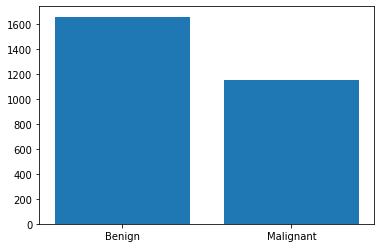

In [ ]:
# This plot shows the R12 vs R45 distribution
%matplotlib inline
plt.bar(['Benign','Malignant'], [df_1[df_1['Malignancy']==0].count()[1], df_1[df_1['Malignancy']==1].count()[1]])  

### We create the Dataset for the CNN
We resize the bounding boxes from 64x64x32 to 32x32x16. The nodule is in the center of the bounding box.

X contains the image data

Y contains the labels - 0 or 1

In [ ]:
# Creating the train and test set to be used for CNN and CNN + Random Forest
msk = np.random.rand(len(df_1)) < 0.8
train_set = df_1[msk]
test_set = df_1[~msk]
(len(train_set), len(test_set))
np.save('gdrive/My Drive/Thesis/Models/Experiment 2/R12R45/train_set.npy', train_set.values)
np.save('gdrive/My Drive/Thesis/Models/Experiment 2/R12R45/test_set.npy', test_set.values)

In [ ]:
X_train = []
Y_train = []
X_test = []
Y_test=  []
for i, x in train_set.iterrows():
    volume = x['3D Volume']
    cropped_volume = volume[8:24, 16:48, 16:48]
    X_train.append(cropped_volume)
    Y_train.append(x['Malignancy'])
for i, x in test_set.iterrows():
    volume = x['3D Volume']
    cropped_volume = volume[8:24, 16:48, 16:48]
    X_test.append(cropped_volume)
    Y_test.append(x['Malignancy'])
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
X_train = X_train.reshape((-1, 32, 32, 16, 1))
X_test = X_test.reshape((-1, 32, 32, 16, 1))

We create the 10 Layer CNN here

In [ ]:
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(X_train.shape[1:]), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(32, padding="same", kernel_size=(3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), padding="same"))

model.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), padding="same"))

model.add(Conv3D(128, padding="same", kernel_size=(3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(128, padding="same", kernel_size=(3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), padding="same"))

model.add(Conv3D(256, padding="same", kernel_size=(3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(256, padding="same", kernel_size=(3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), padding="same"))

model.add(Conv3D(512, padding="same", kernel_size=(3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(512, padding="same", kernel_size=(3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Flatten())
# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))
model.add(Dense(1, activation='sigmoid'))


model.summary()




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 32, 32, 16, 32)    896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 16, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16, 32)    128       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 32, 32, 16, 32)    27680     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 16, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 16, 32)    128       
__

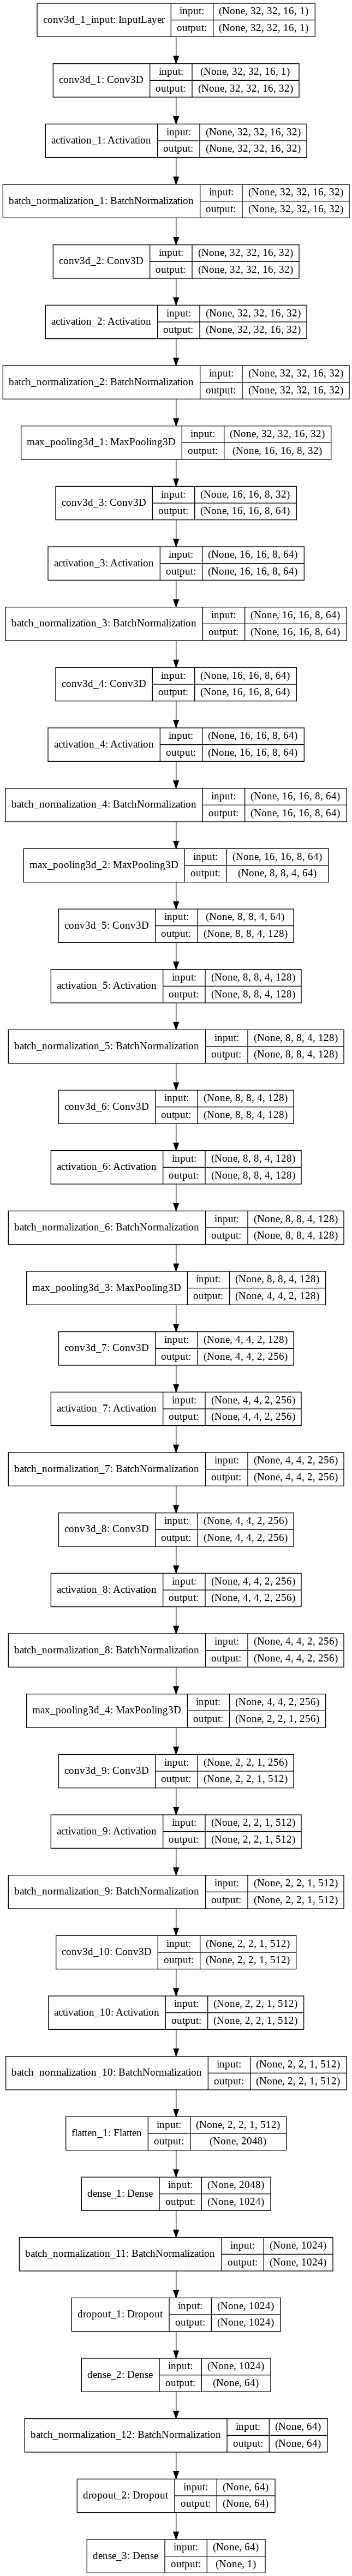

In [ ]:
# Visualizing the CNN
from keras.utils import plot_model
plot_model(model, to_file='gdrive/My Drive/Thesis/CNN-10-model.png', show_shapes=True)

Hyperparameters:
- Learning Rate is 0.0001
- Binary crossentropy is used as the loss function
- Adam optimizer used

In [ ]:
#compile model using accuracy to measure model performance
adam = optimizers.adam(lr=0.0001)
# decay=1e-6
# model.compile(loss='mean_squared_error', optimizer=sgd)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
#train the model
history_1 = model.fit(X_train, Y_train, validation_split=0.2, batch_size = 32, verbose=2, epochs=32)




Train on 1798 samples, validate on 450 samples
Epoch 1/32





 - 34s - loss: 14.7193 - acc: 0.6502 - val_loss: 12.7962 - val_acc: 0.7578
Epoch 2/32
 - 7s - loss: 12.0186 - acc: 0.7080 - val_loss: 11.3422 - val_acc: 0.7578
Epoch 3/32
 - 7s - loss: 11.1106 - acc: 0.7430 - val_loss: 10.8737 - val_acc: 0.7311
Epoch 4/32
 - 7s - loss: 10.7200 - acc: 0.7670 - val_loss: 10.8471 - val_acc: 0.7222
Epoch 5/32
 - 7s - loss: 10.4506 - acc: 0.7931 - val_loss: 10.5350 - val_acc: 0.6800
Epoch 6/32
 - 7s - loss: 10.2188 - acc: 0.8131 - val_loss: 10.2898 - val_acc: 0.7267
Epoch 7/32
 - 7s - loss: 9.9416 - acc: 0.8426 - val_loss: 9.9389 - val_acc: 0.7889
Epoch 8/32
 - 7s - loss: 9.7385 - acc: 0.8343 - val_loss: 9.8862 - val_acc: 0.7556
Epoch 9/32
 - 7s - loss: 9.4629 - acc: 0.8637 - val_loss: 9.6291 - val_acc: 0.7178
Epoch 10/32
 - 7s - loss: 9.2427 - acc: 0.8654 - val_loss: 9.3346 - val_acc: 0.7667
Epoch 11/32
 - 7s - loss: 8.9617 - acc: 0.8832 - val_loss: 9.0871 - val_acc: 0.7778
Epoch 12/32
 - 7s

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("gdrive/My Drive/Thesis/Models/Experiment 2/R12R45/CNN10-model-R12R45.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("gdrive/My Drive/Thesis/Models/Experiment 2/R12R45/CNN10-model-R12R45.h5")
print("Saved model to disk")


Saved model to disk


In [ ]:
from keras.models import model_from_json
# load json and create model
json_file = open('gdrive/My Drive/Thesis/Models/CNN10-model-R12R45.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("gdrive/My Drive/Thesis/Models/CNN10-model-R12R45.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
print(history_1.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


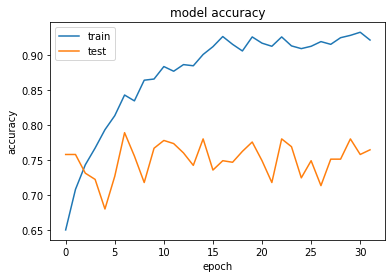

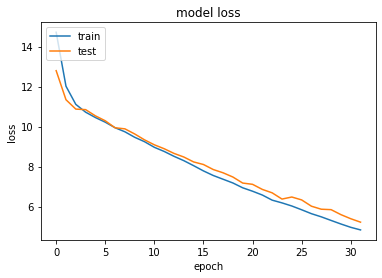

In [ ]:
# summarize history for accuracy
plt.plot(history_1.history['acc'])
plt.plot(history_1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
evals = model.evaluate(X_test, Y_test)
print('Accuracy is:',evals[1])
print('Loss is:',evals[0])

569/569 [==============================] - 1s 1ms/step
Accuracy is: 0.7082601057624146
Loss is: 5.413239677677255


Now we calculate the ROC AUC and plot the ROC Curve for the CNN on Distributuion 1

In [ ]:
# Function to calculate ROC
def roc(real_labels, predicted_probability):
    tpr = []
    fpr = []
    thresh=0.0


    #for i in range(0,100):
    #    sens_spec.append([])


    for i in range(100):
        nTruePos = 0
        nPos = 0
        nFalsePos = 0
        nNeg = 0
        for j, label in enumerate(real_labels):
            #print("real_labels[i] " + str(real_labels[j]))
            if (label == 1):   # if a cancer image
                nPos += 1
                if (predicted_probability[j] > thresh):     # if we predict cancer
                    nTruePos += 1
            else:                          # a non-cancer image
                nNeg += 1
                if (predicted_probability[j] > thresh):
                    nFalsePos += 1
#         print("thresh " + str(thresh) + " nTruePos " + str(nTruePos) + " nPos " + str(nPos) + " nFalsePos " + str(nFalsePos) + " nNeg " + str(nNeg))
        tpr.append( float(nTruePos) / float(nPos) )
        fpr.append( float(nFalsePos) / float(nNeg) )
        thresh+=0.01
    return tpr, fpr

In [ ]:
predict_proba = model.predict_proba(X_test)
fpr_1, tpr_1, threshold = metrics.roc_curve(Y_test, predict_proba)
auc_score = metrics.roc_auc_score(Y_test, predict_proba)

[]

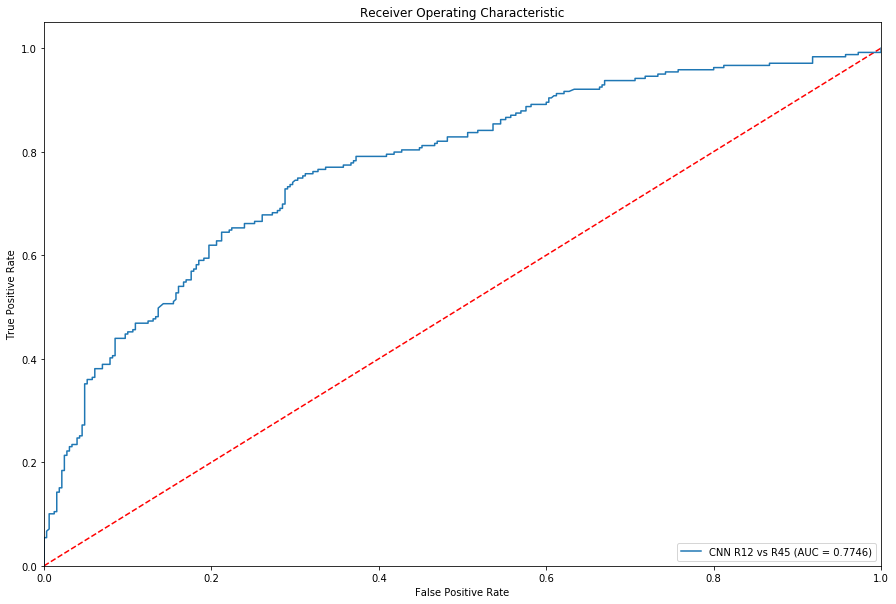

In [ ]:
plt.figure(figsize=(15,10))
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_1, tpr_1, label='CNN R12 vs R45 (AUC = %0.4f)' % auc_score)
plt.legend(loc='lower right')
plt.plot()

We extract the feature vector for all bounding boxes from the last layer of the CNN and pair that feature vector with it's corresponding labels. 
We then train a random forest on this feature vector and label pair dataset 1000 times on every 80:20 split and observe the ROC AUC distribution.

We also plot the ROC Curve comparing the ROC with just CNN and ROC with CNN + Random Forest. 

Note: This is for images ONLY

In [ ]:
# Extract the feature vector
from keras.models import Model
layer_name = 'dense_2'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output_train = intermediate_layer_model.predict(X_train)
intermediate_output_test = intermediate_layer_model.predict(X_test)

In [ ]:
# Create the Feature vectore and label pair
rfData_train = intermediate_output_train.tolist()
rfData_test = intermediate_output_test.tolist()
rfLabel_train = Y_train.tolist()
rfLabel_test = Y_test.tolist()
features_df_train = pd.DataFrame({'Feature_train':rfData_train, 'Malignancy_train':rfLabel_train})
features_df_test = pd.DataFrame({'Feature_test':rfData_test, 'Malignancy_test':rfLabel_test})

We calculate the ROC AUC for 1000 iterations of the random forest training on the feature vector dataset and plot the distribution

In [ ]:
# AUCS = []
# tprs = []
# fprs = []
train_set = features_df_train.copy()
train_data = train_set.Feature_train.values.tolist()
train_label = train_set.Malignancy_train.values.astype('int32')
test_set = features_df_test.copy()
test_data = test_set.Feature_test.values.tolist()
test_label = test_set.Malignancy_test.values.astype('int32')
# Train the random forest
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(train_data, train_label)
# Get the AUC
randomForestAUC = metrics.roc_auc_score(test_label, rf.predict_proba(test_data)[:,1])
# AUCS.append(randomForestAUC)
fpr_2, tpr_2, threshold = metrics.roc_curve(test_label, rf.predict_proba(test_data)[:,1])
# tprs.append(tpr)
# fprs.append(fpr)


[]

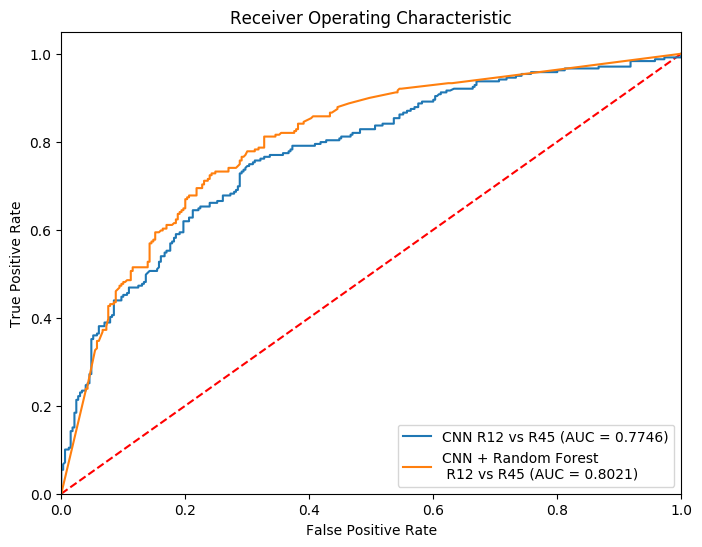

In [ ]:
# Plot for the ROC AUC on the maximum AUC
plt.style.use('default')
plt.figure(figsize=(8,6))
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_1, tpr_1, label='CNN R12 vs R45 (AUC = %0.4f)' % auc_score)
plt.plot(fpr_2, tpr_2, label='CNN + Random Forest\n R12 vs R45 (AUC = %0.4f)' % randomForestAUC)
plt.legend(loc='lower right')
plt.plot()

In [ ]:
# Save random forest AUC's and TPR's and FPR's
np.save('gdrive/My Drive/Thesis/Models/Experiment 2/R12R45/CNN-RF-R12R45-AUC.npy', np.array(randomForestAUC))
np.save('gdrive/My Drive/Thesis/Models/Experiment 2/R12R45/CNN-RF-R12R45-TPR.npy', np.array(tpr_2))
np.save('gdrive/My Drive/Thesis/Models/Experiment 2/R12R45/CNN-RF-R12R45-FPR.npy', np.array(fpr_2))

In [ ]:
# Save CNN AUC and TPR and FPR
np.save('gdrive/My Drive/Thesis/Models/Experiment 2/R12R45/CNN-R12R45-AUC.npy', np.array(auc_score))
np.save('gdrive/My Drive/Thesis/Models/Experiment 2/R12R45/CNN-R12R45-TPR.npy', np.array(tpr_1))
np.save('gdrive/My Drive/Thesis/Models/Experiment 2/R12R45/CNN-R12R45-FPR.npy', np.array(fpr_1))

# Distribution 2 - R123 vs R345

In [ ]:
# df_2 will contain nodules belonging to R12 (Benign), R45(Malignant) and R3(Intermediate)
df_2 = df_curated.copy()
df_2.loc[df_2['Malignancy']<=2, ['Malignancy']] = 0
df_2.loc[df_2['Malignancy']>=4, ['Malignancy']] = 1
len(df_2)

4505

<BarContainer object of 3 artists>

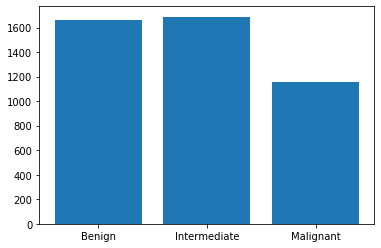

In [ ]:
# This plot shows the R12 vs R45 distribution
%matplotlib inline
plt.bar(['Benign','Intermediate','Malignant'], [df_2[df_2['Malignancy']==0].count()[1], df_2[df_2['Malignancy']==3].count()[1], df_2[df_2['Malignancy']==1].count()[1]])  

In [ ]:
# Create the train and test set
msk = np.random.rand(len(df_2)) < 0.8
train_set = df_2[msk]
test_set = df_2[~msk]


In [ ]:
# Train the KNN on the training set and classify the intermediate malignancy nodules in the training set only
print('Global train set contains nodules with malignancy values', train_set.Malignancy.unique(),' Before KNN step')
# KNN train set contains R12 and R45 nodules of the global train set
knn_train_set = train_set[train_set['Malignancy']!=3]
print('KNN train set contains nodules with malignancy values', knn_train_set.Malignancy.unique())
# Using only the biomarkers in the training set
knn_train = knn_train_set[["subtlety", "internalStructure","calcification","sphericity","margin","lobulation","spiculation","texture"]].values.astype('int32')
knn_labels = knn_train_set.Malignancy.values.astype('int32')

#train the KNN on K=21
knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(knn_train, knn_labels)

Global train set contains nodules with malignancy values [1 3 0]  Before KNN step
KNN train set contains nodules with malignancy values [1 0]


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='uniform')

In [ ]:
# We now classify the nodules with malignancy 3 into 'Malignant'(1)  or 'Benign'(0)
knn_to_predict = train_set[train_set['Malignancy']==3][["subtlety", "internalStructure","calcification","sphericity","margin","lobulation","spiculation","texture"]].values.astype('int32')
preds = knn.predict(knn_to_predict)

In [ ]:
# Now we must assign the predicted values to the nodules that have malignancy 3
print('Verifying that we have predicted every Malignancy 3 level nodule in the global training step')
print('--------------------------------------------------------------------------------------------')
print('Total number of nodules with malignancy 3 in the global train set:', train_set[train_set['Malignancy']==3].count()[0])
print('Total number of predictions:', len(preds))
print('Unique values of the predictions:', set(preds))
print('--------------------------------------------------------------------------------------------')
print('Assigning the predicted values...')
global_train_set = train_set.copy()
global_test_set = test_set.copy()
j=0
for i, x in global_train_set.iterrows():
    if x['Malignancy'] == 3:
        global_train_set.at[i, 'Malignancy'] =  preds[j]
        j+=1
print('Assigned!')
print('---------------------------------------------------------------------------------------------')
print('Number of nodules with malignancy 3 in global train set:', train_set[train_set['Malignancy']==3].count()[0])
print('Unique malignancy values in the global train set:', train_set.Malignancy.unique())
print('Number of nodules in global train set:', len(train_set))

Verifying that we have predicted every Malignancy 3 level nodule in the global training step
--------------------------------------------------------------------------------------------
Total number of nodules with malignancy 3 in the global train set: 1357
Total number of predictions: 1357
Unique values of the predictions: {0, 1}
--------------------------------------------------------------------------------------------
Assigning the predicted values...
Assigned!
---------------------------------------------------------------------------------------------
Number of nodules with malignancy 3 in global train set: 1357
Unique malignancy values in the global train set: [1 3 0]
Number of nodules in global train set: 3626


In [ ]:
# Remove Nodules belonging to class 3 in global test set
global_test_set = global_test_set[test_set['Malignancy']!=3]
print('Unique malignancy values in global test set:', global_test_set.Malignancy.unique())

Unique malignancy values in global test set: [1 0]


In [ ]:
print('Number of training nodules are', len(global_train_set))
print('Number of testing nodules are', len(global_test_set))

Number of training nodules are 3626
Number of testing nodules are 548


Since this is not a 80:20 split anymore, we must get add some of the nodules with malignancy 1 and 0 BEFORE knn from the train set into the new test set that we have just created

In [ ]:
# Before that, let's compare our Train set before KNN and train set after KNN
print('Length of Train set before KNN:',len(train_set))
print('Length of Train set after KNN:', len(global_train_set))
# The lengths must be the same. If they are, we also know exactly which rows were previosly M3 nodules in the new train set
print('Old train set - first 20 values')
train_set[:20]

Length of Train set before KNN: 3626
Length of Train set after KNN: 3626
Old train set - first 20 values


,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,Malignancy,Patient_id,3D Volume,3D Mask
0,5,1,6,3,3,3,4,5,1,LIDC-IDRI-0001,"[[[-35.0, -364.0, -769.0, -883.0, -882.0, -851...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,5,1,6,4,4,5,5,5,1,LIDC-IDRI-0001,"[[[-603.0, -808.0, -825.0, -858.0, -879.0, -86...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,5,1,6,3,2,3,3,5,1,LIDC-IDRI-0001,"[[[-567.0, -838.0, -875.0, -876.0, -856.0, -84...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,2,1,6,5,1,1,1,1,1,LIDC-IDRI-0002,"[[[-863.0, -866.0, -827.0, -821.0, -876.0, -91...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
6,5,1,6,3,3,2,2,3,1,LIDC-IDRI-0003,"[[[419.0, 369.0, 138.0, -290.0, -656.0, -824.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
7,4,1,6,3,4,1,1,5,1,LIDC-IDRI-0003,"[[[132.0, 132.0, 130.0, 109.0, 107.0, 111.0, 9...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
8,4,1,6,4,5,1,1,5,1,LIDC-IDRI-0003,"[[[-709.0, -704.0, -711.0, -698.0, -829.0, -89...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
9,5,1,6,4,3,2,2,5,1,LIDC-IDRI-0003,"[[[149.0, -161.0, -529.0, -745.0, -834.0, -869...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
10,5,1,6,5,5,1,1,5,1,LIDC-IDRI-0003,"[[[-599.0, -643.0, -773.0, -904.0, -898.0, -87...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
11,4,1,6,4,4,2,2,5,1,LIDC-IDRI-0003,"[[[103.0, 94.0, 86.0, 79.0, 78.0, 85.0, 86.0, ...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [ ]:
print('New Train set - first 20 values')
global_train_set[:20]

New Train set - first 20 values


,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,Malignancy,Patient_id,3D Volume,3D Mask
0,5,1,6,3,3,3,4,5,1,LIDC-IDRI-0001,"[[[-35.0, -364.0, -769.0, -883.0, -882.0, -851...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,5,1,6,4,4,5,5,5,1,LIDC-IDRI-0001,"[[[-603.0, -808.0, -825.0, -858.0, -879.0, -86...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,5,1,6,3,2,3,3,5,1,LIDC-IDRI-0001,"[[[-567.0, -838.0, -875.0, -876.0, -856.0, -84...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,2,1,6,5,1,1,1,1,1,LIDC-IDRI-0002,"[[[-863.0, -866.0, -827.0, -821.0, -876.0, -91...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
6,5,1,6,3,3,2,2,3,1,LIDC-IDRI-0003,"[[[419.0, 369.0, 138.0, -290.0, -656.0, -824.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
7,4,1,6,3,4,1,1,5,1,LIDC-IDRI-0003,"[[[132.0, 132.0, 130.0, 109.0, 107.0, 111.0, 9...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
8,4,1,6,4,5,1,1,5,1,LIDC-IDRI-0003,"[[[-709.0, -704.0, -711.0, -698.0, -829.0, -89...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
9,5,1,6,4,3,2,2,5,1,LIDC-IDRI-0003,"[[[149.0, -161.0, -529.0, -745.0, -834.0, -869...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
10,5,1,6,5,5,1,1,5,1,LIDC-IDRI-0003,"[[[-599.0, -643.0, -773.0, -904.0, -898.0, -87...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
11,4,1,6,4,4,2,2,5,1,LIDC-IDRI-0003,"[[[103.0, 94.0, 86.0, 79.0, 78.0, 85.0, 86.0, ...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


We have a good KNN split, but since we remove all M3 nodules from test set, our test set has now become smaller. This is shown below


In [ ]:
print('Length of test set before KNN:', len(test_set))
perc_before_knn = len(test_set)/(len(test_set)+len(train_set))
print('percentage of test set before KNN:',perc_before_knn*100,'%')
print('Length of test set after KNN:', len(global_test_set))
perc_after_knn = len(global_test_set)/(len(global_test_set)+len(global_train_set))
print('percentage of test set after KNN:',perc_after_knn*100,'%')
perc_needed = (perc_before_knn - perc_after_knn)
needed_num_rows = perc_needed * (len(global_test_set)+len(global_train_set))
print('We need',perc_needed*100,'% of data in the test set. That is',int(needed_num_rows),'rows')
print('Train set after KNN has these extra rows, so we can transfer it from there')

Length of test set before KNN: 879
percentage of test set before KNN: 19.51165371809101 %
Length of test set after KNN: 548
percentage of test set after KNN: 13.128893148059415 %
We need 6.3827605700315955 % of data in the test set. That is 266 rows
Train set after KNN has these extra rows, so we can transfer it from there


In [ ]:
temp = train_set.copy()
# This removes the M3 nodules but retains the orignal indexes. WE ONLY PICK THE NODULES WHOSE MALIGNANCY HAS ALWAYS BEEN 1 or 0.
temp = temp[temp['Malignancy']!=3]
# get the needed rows index values from this train set
needed = temp.sample(n=int(needed_num_rows))
# Check if the needed rows index values are in the test set
for i in needed.index.values:
  if i in global_test_set.index.values:
    print(i)
# Nothing should be printed, we are good to go. We can now append the needed rows into the test set after knn
# global_test_set.append(needed, verify_integrity=True)
# print(global_test_set.Malignancy.unique())

In [ ]:
global_test_set = global_test_set.append(needed, verify_integrity=True)

In [ ]:
print('The length of the test set after adding the needed rows is', len(global_test_set))
# Now we must remove these rows from the global train set
global_train_set = global_train_set.drop(needed.index.values)

The length of the test set after adding the needed rows is 814


In [ ]:
print('The length of global train set after removing the needed test data points is:',len(global_train_set))
# lets make sure that train set and test set values are unique
# This should not print anything
for i in global_train_set.index.values:
  if i in global_test_set.index.values:
    print(i)

# Train set and Test set are disjoint. Let's see the percentage of these two sets now
print('Total number of data points before KNN:', len(test_set)+len(train_set))
print('Total number of data points after KNN:', len(global_test_set)+len(global_train_set)) #Must be lesser because we remove M3 nodules from test set
perc_train = len(global_train_set) / (len(global_train_set)+len(global_test_set))
perc_test = len(global_test_set) / (len(global_test_set)+len(global_train_set))
print('Percentage of Training data after KNN:', perc_train*100)
print('Percentage of Testing data after KNN:', perc_test*100)

# Yes! we have successfully ensured that the test and train data have the same percentage and the test set has only R12 and R45 values, whereas the train set has some
# previous R3 that has been classified using KNN. 

The length of global train set after removing the needed test data points is: 3360
Total number of data points before KNN: 4505
Total number of data points after KNN: 4174
Percentage of Training data after KNN: 80.49832295160518
Percentage of Testing data after KNN: 19.501677048394825


# Create the dataset


In [ ]:
np.save('gdrive/My Drive/Thesis/Models/Experiment 2/R123R345/train_set.npy', global_train_set.values)
np.save('gdrive/My Drive/Thesis/Models/Experiment 2/R123R345/test_set.npy', global_test_set.values)

In [ ]:
X_train = []
Y_train = []
X_test = []
Y_test=  []
for i, x in global_train_set.iterrows():
    volume = x['3D Volume']
    cropped_volume = volume[8:24, 16:48, 16:48]
    X_train.append(cropped_volume)
    Y_train.append(x['Malignancy'])
for i, x in global_test_set.iterrows():
    volume = x['3D Volume']
    cropped_volume = volume[8:24, 16:48, 16:48]
    X_test.append(cropped_volume)
    Y_test.append(x['Malignancy'])
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
X_train = X_train.reshape((-1, 32, 32, 16, 1))
X_test = X_test.reshape((-1, 32, 32, 16, 1))

In [ ]:
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(X_train.shape[1:]), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(32, padding="same", kernel_size=(3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), padding="same"))

model.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), padding="same"))

model.add(Conv3D(128, padding="same", kernel_size=(3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(128, padding="same", kernel_size=(3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), padding="same"))

model.add(Conv3D(256, padding="same", kernel_size=(3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(256, padding="same", kernel_size=(3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), padding="same"))

model.add(Conv3D(512, padding="same", kernel_size=(3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(512, padding="same", kernel_size=(3, 3, 3), kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Flatten())
# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))
model.add(Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 32, 32, 16, 32)    896       
_________________________________________________________________
activation_11 (Activation)   (None, 32, 32, 16, 32)    0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 16, 32)    128       
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 32, 32, 16, 32)    27680     
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 16, 32)    0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 16, 32)    128       
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 16, 16, 8, 32)    

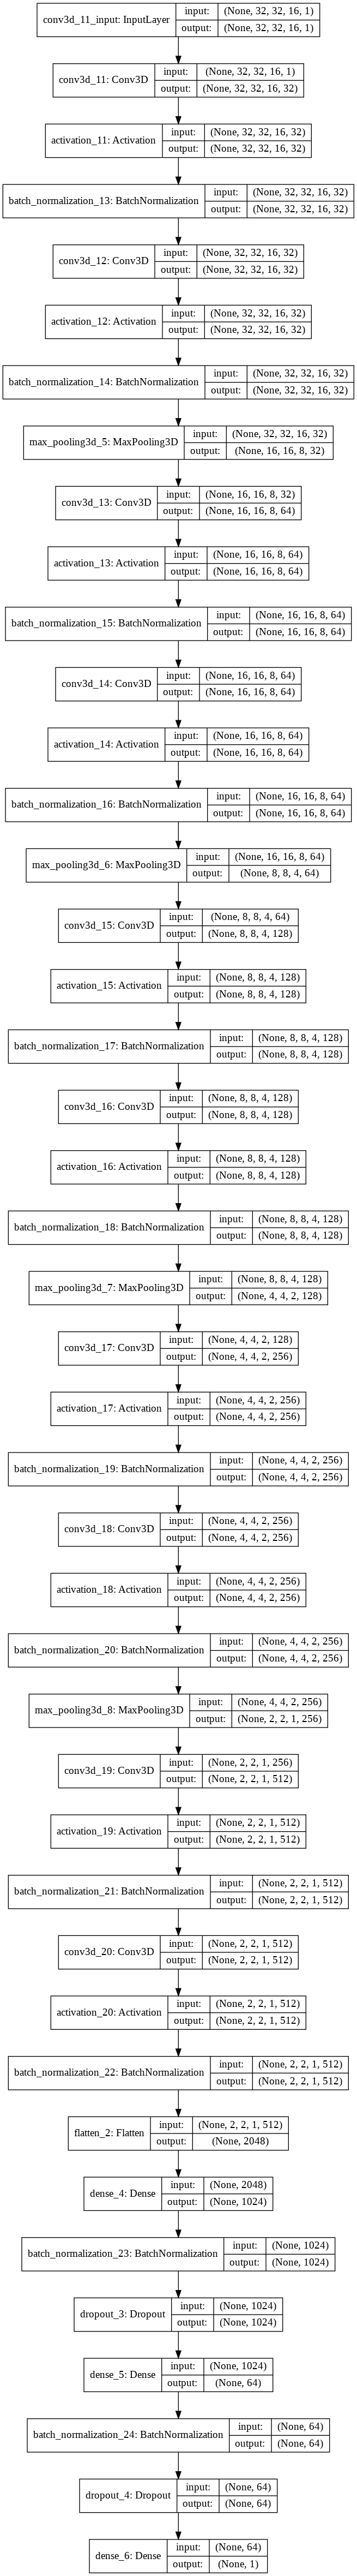

In [ ]:
# Visualizing the CNN
from keras.utils import plot_model
plot_model(model, to_file='gdrive/My Drive/Thesis/CNN-10-R123R345-model.png', show_shapes=True)

In [ ]:
#compile model using accuracy to measure model performance
adam = optimizers.adam(lr=0.0001)
# decay=1e-6
# model.compile(loss='mean_squared_error', optimizer=sgd)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#train the model
history_2 = model.fit(X_train, Y_train, validation_split=0.2, batch_size = 32, verbose=2, epochs=32)

Train on 2688 samples, validate on 672 samples
Epoch 1/32
 - 21s - loss: 14.0710 - acc: 0.6068 - val_loss: 12.4679 - val_acc: 0.5164
Epoch 2/32
 - 8s - loss: 11.4385 - acc: 0.6674 - val_loss: 11.0671 - val_acc: 0.6592
Epoch 3/32
 - 8s - loss: 10.8105 - acc: 0.6972 - val_loss: 10.7472 - val_acc: 0.5833
Epoch 4/32
 - 8s - loss: 10.4404 - acc: 0.7269 - val_loss: 10.3910 - val_acc: 0.6830
Epoch 5/32
 - 8s - loss: 10.1124 - acc: 0.7355 - val_loss: 10.2868 - val_acc: 0.5193
Epoch 6/32
 - 8s - loss: 9.7581 - acc: 0.7552 - val_loss: 9.8190 - val_acc: 0.6592
Epoch 7/32
 - 8s - loss: 9.3984 - acc: 0.7809 - val_loss: 9.4923 - val_acc: 0.6205
Epoch 8/32
 - 8s - loss: 9.0486 - acc: 0.7846 - val_loss: 9.0729 - val_acc: 0.6458
Epoch 9/32
 - 8s - loss: 8.7034 - acc: 0.8002 - val_loss: 8.7523 - val_acc: 0.6339
Epoch 10/32
 - 8s - loss: 8.3447 - acc: 0.8065 - val_loss: 8.5192 - val_acc: 0.6771
Epoch 11/32
 - 8s - loss: 8.0185 - acc: 0.8095 - val_loss: 8.1133 - val_acc: 0.6801
Epoch 12/32
 - 8s - loss: 7

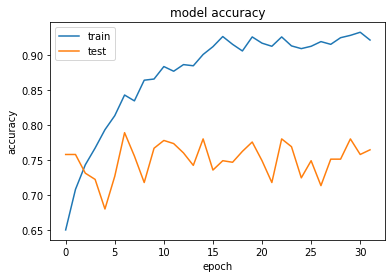

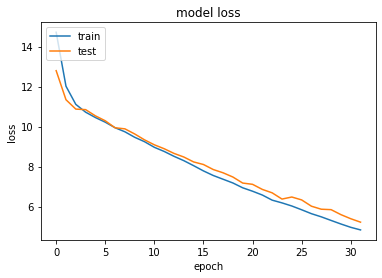

In [ ]:
# summarize history for accuracy
plt.plot(history_1.history['acc'])
plt.plot(history_1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
evals = model.evaluate(X_test, Y_test)
print('Accuracy is:',evals[1])
print('Loss is:',evals[0])

814/814 [==============================] - 1s 995us/step
Accuracy is: 0.7260442257513285
Loss is: 3.5753601487790045


In [ ]:
predict_proba = model.predict_proba(X_test)
fpr_3, tpr_3, threshold = metrics.roc_curve(Y_test, predict_proba)
auc_score_3 = metrics.roc_auc_score(Y_test, predict_proba)

[]

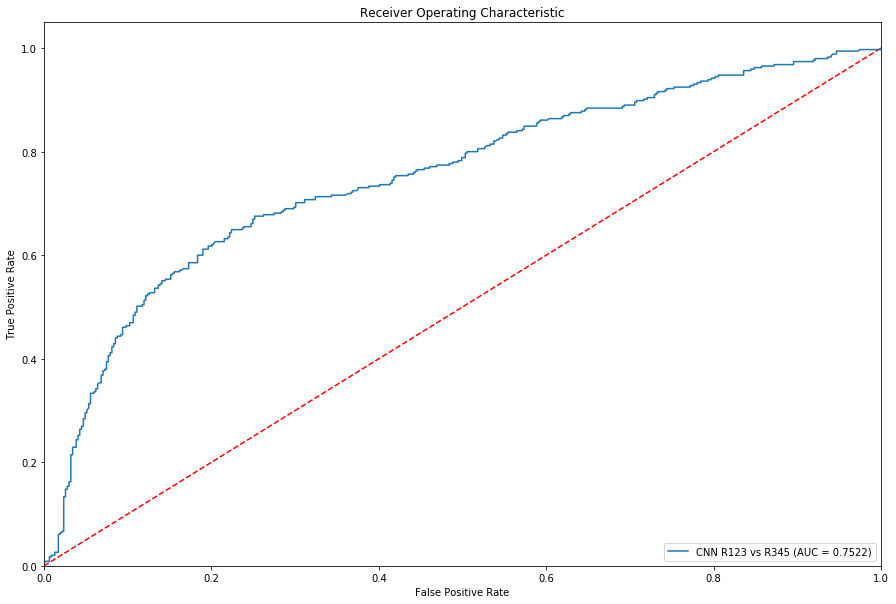

In [ ]:
plt.figure(figsize=(15,10))
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_3, tpr_3, label='CNN R123 vs R345 (AUC = %0.4f)' % auc_score_3)
plt.legend(loc='lower right')
plt.plot()

In [ ]:
# Extract the feature vector
from keras.models import Model
layer_name = 'dense_5'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output_train = intermediate_layer_model.predict(X_train)
intermediate_output_test = intermediate_layer_model.predict(X_test)

In [ ]:
# Create the Feature vectore and label pair
rfData_train = intermediate_output_train.tolist()
rfData_test = intermediate_output_test.tolist()
rfLabel_train = Y_train.tolist()
rfLabel_test = Y_test.tolist()
features_df_train = pd.DataFrame({'Feature_train':rfData_train, 'Malignancy_train':rfLabel_train})
features_df_test = pd.DataFrame({'Feature_test':rfData_test, 'Malignancy_test':rfLabel_test})

In [ ]:
# AUCS = []
# tprs = []
# fprs = []
train_set = features_df_train.copy()
train_data = train_set.Feature_train.values.tolist()
train_label = train_set.Malignancy_train.values.astype('int32')
test_set = features_df_test.copy()
test_data = test_set.Feature_test.values.tolist()
test_label = test_set.Malignancy_test.values.astype('int32')
# Train the random forest
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(train_data, train_label)
# Get the AUC
randomForestAUC_2 = metrics.roc_auc_score(test_label, rf.predict_proba(test_data)[:,1])
# AUCS.append(randomForestAUC)
fpr_4, tpr_4, threshold = metrics.roc_curve(test_label, rf.predict_proba(test_data)[:,1])
# tprs.append(tpr)
# fprs.append(fpr)


[]

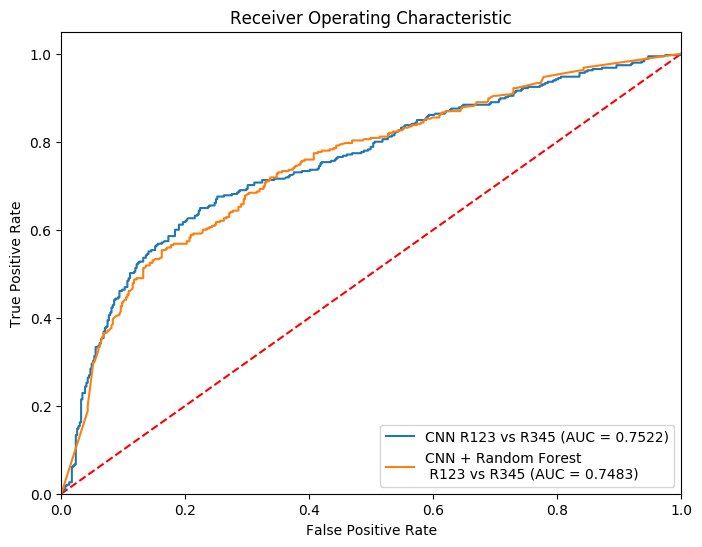

In [ ]:
# Plot for the ROC AUC on the maximum AUC
plt.style.use('default')
plt.figure(figsize=(8,6))
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_3, tpr_3, label='CNN R123 vs R345 (AUC = %0.4f)' % auc_score_3)
# plt.plot(fprs[max_index], tprs[max_index], label='CNN + Random Forest\n R12 vs R45 (AUC = %0.4f)' % max(AUCS))
plt.plot(fpr_4, tpr_4, label='CNN + Random Forest\n R123 vs R345 (AUC = %0.4f)' % randomForestAUC_2)
plt.legend(loc='lower right')
plt.plot()

In [ ]:
# Save random forest AUC's and TPR's and FPR's
np.save('gdrive/My Drive/Thesis/Models/Experiment 2/R123R345/CNN-RF-R123R345-AUC.npy', np.array(randomForestAUC_2))
np.save('gdrive/My Drive/Thesis/Models/Experiment 2/R123R345/CNN-RF-R123R345-TPR.npy', np.array(tpr_4))
np.save('gdrive/My Drive/Thesis/Models/Experiment 2/R123R345/CNN-RF-R123R345-FPR.npy', np.array(fpr_4))

In [ ]:
# Save CNN AUC and TPR and FPR
np.save('gdrive/My Drive/Thesis/Models/Experiment 2/R123R345/CNN-R123R345-AUC.npy', np.array(auc_score_3))
np.save('gdrive/My Drive/Thesis/Models/Experiment 2/R123R345/CNN-R123R345-TPR.npy', np.array(tpr_3))
np.save('gdrive/My Drive/Thesis/Models/Experiment 2/R123R345/CNN-R123R345-FPR.npy', np.array(fpr_3))

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("gdrive/My Drive/Thesis/Models/Experiment 2/R123R345/CNN10-model-R123R345.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("gdrive/My Drive/Thesis/Models/Experiment 2/R123R345/CNN10-model-R123R345.h5")
print("Saved model to disk")


Saved model to disk


[]

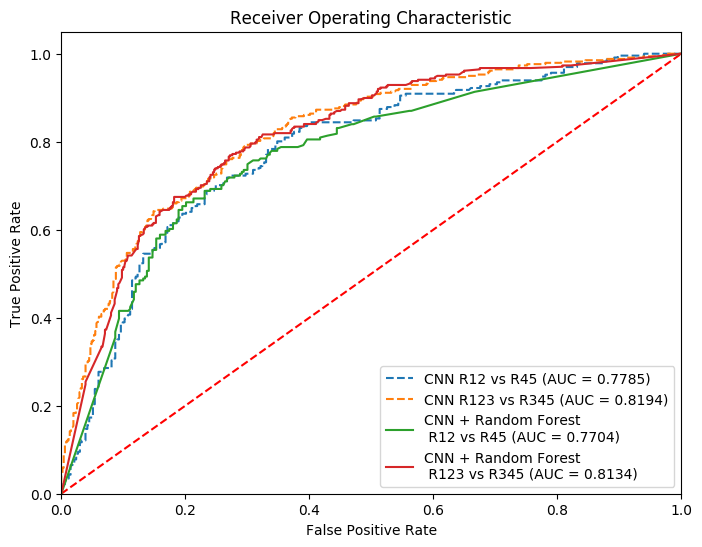

In [ ]:
# Plot for the ROC AUC on the maximum AUC
plt.style.use('default')
plt.figure(figsize=(8,6))
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_1, tpr_1, label='CNN R12 vs R45 (AUC = %0.4f)' % auc_score, linestyle='dashed')
plt.plot(fpr_2, tpr_2, label='CNN R123 vs R345 (AUC = %0.4f)' % auc_score_2, linestyle='dashed')

# plt.plot(fprs[max_index], tprs[max_index], label='CNN + Random Forest\n R12 vs R45 (AUC = %0.4f)' % max(AUCS))
plt.plot(fpr, tpr, label='CNN + Random Forest\n R12 vs R45 (AUC = %0.4f)' % randomForestAUC)
plt.plot(fpr_3, tpr_3, label='CNN + Random Forest\n R123 vs R345 (AUC = %0.4f)' % randomForestAUC_3)
plt.legend(loc='lower right')
plt.plot()